# **Advanced Machine Learning - Assignment 1**

Let's define the training dataset import function, fetching directly from the Github repo.

In [2]:

from numpy.random import seed
import tensorflow as tf
import pandas as pd

seed(961106)
tf.random.set_seed(61196)

def merge_training_dataset(feature_set, label_set):
    merged = pd.merge(feature_set, label_set, on='id')
    return merged

def import_training_dataset():
  url_features = 'https://github.com/AlbezJelt/AML_Assignment1/raw/main/data/X_train.csv'
  url_labels = 'https://github.com/AlbezJelt/AML_Assignment1/raw/main/data/y_train.csv'
  feature_set = pd.read_csv(url_features).rename(columns={'Unnamed: 0':'id'})
  label_set = pd.read_csv(url_labels).rename(columns={'Unnamed: 0':'id'})
  train_set = merge_training_dataset(feature_set, label_set)
  train_set.drop('id', axis=1, inplace=True)
  return train_set

train_set = import_training_dataset()
test_set = train_set.sample(frac=0.2, random_state=42)
train_set = train_set.drop(test_set.index)


Now we can explore the pandas datasets:

In [2]:
import seaborn as sns

train_stats = train_set.describe()
train_stats.pop("latitude")
train_stats.pop("longitude")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
minimum_nights,27107.0,7.166562,19.936023,1.0,1.00,3.00,5.00,999.0
number_of_reviews,27107.0,23.310510,44.342583,0.0,1.00,5.00,23.00,629.0
reviews_per_month,27107.0,1.093855,1.618335,0.0,0.04,0.37,1.59,58.5
calculated_host_listings_count,27107.0,7.251743,33.307034,1.0,1.00,1.00,2.00,327.0
availability_365,27107.0,112.831925,131.551035,0.0,0.00,45.00,226.00,365.0
Private_room,27107.0,0.455307,0.498008,0.0,0.00,0.00,1.00,1.0
Entire_home/apt,27107.0,0.521194,0.499560,0.0,0.00,1.00,1.00,1.0
price,27107.0,153.695724,253.309864,0.0,69.00,105.00,176.00,10000.0


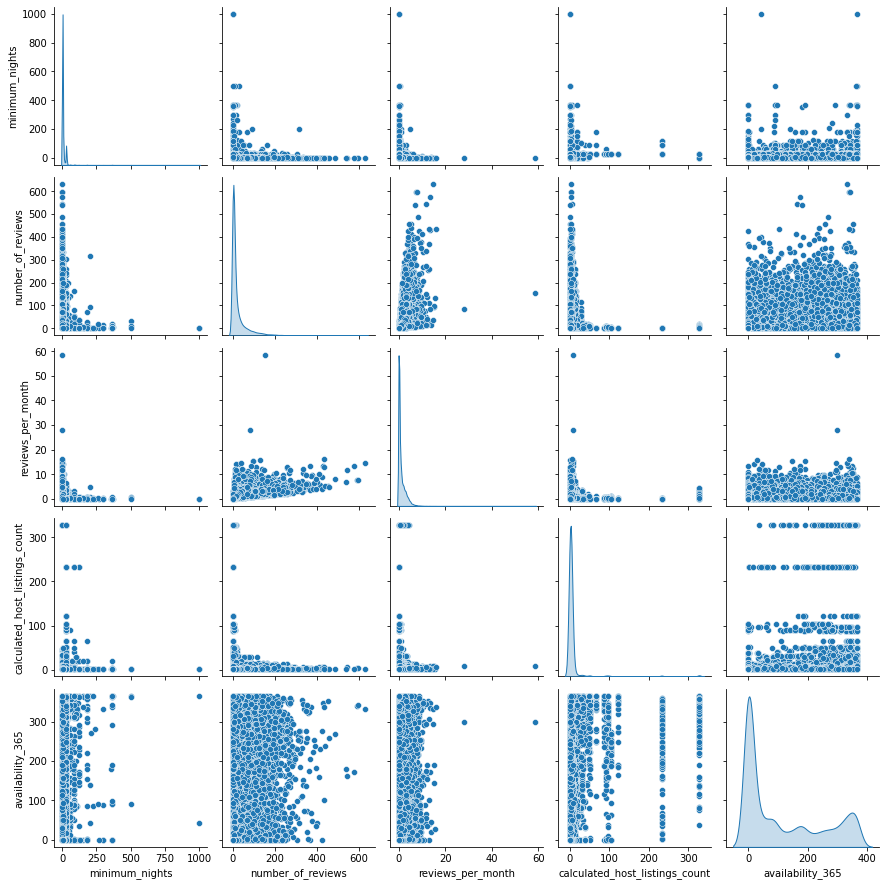

In [3]:
sns.pairplot(train_set[["minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]], diag_kind="kde")

Now we begin with the model creation. First of all we sepair the labels (in this case the price column) from the train set. 

In [5]:
import numpy as np

def prepare_data(train_set, test_set):
    Y_train = train_set.copy().pop("price").to_numpy(dtype=np.float32)
    Y_test = test_set.copy().pop("price").to_numpy(dtype=np.float32)
    return train_set.copy().to_numpy(dtype=np.float32), Y_train, test_set.copy().to_numpy(dtype=np.float32), Y_test

X_train, Y_train, X_test, Y_test = prepare_data(train_set, test_set)

Then we proceed to normalize data. Remember to normalize the validation set too.

In [6]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X : np.ndarray, scaler=None):
    if not scaler:
        scaler = StandardScaler()
    if X.ndim == 1:
        X = np.squeeze(scaler.fit_transform(X.reshape(-1, 1)))
    else:
        X = scaler.fit_transform(X)      
    return X

X_train = preprocess_data(X_train)
Y_train = preprocess_data(Y_train)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_model(train_dataset, hl_size, activation):
  model = keras.Sequential([
    layers.Dense(hl_size, activation=activation, input_shape=(X_train.shape[1], )),
    layers.Dense(hl_size, activation=activation),
    layers.Dense(hl_size, activation=activation),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.RMSprop(0.001)

  model.compile(loss=root_mean_squared_error,
                optimizer=optimizer,
                metrics=[root_mean_squared_error, 'mse'])
  return model

Now that we have a function to build and compile parametrizied model we can search for the best model simply running a **search** on some combination of:


*   Number of epochs.
*   Batch sizes.
*   Neurons per layer.
*   Activaton functions.

Then to estimate the best model for given combination, i.e. **the one that minimise the RMSE**,  we exploit the k-fold cross validation with 10 fold.

So, let's start defining the search parameters...



In [16]:
import itertools

EPOCHS = [50, 100, 150]
BATCH_SIZE = [32, 64, 128]
NEURON_PER_LAYER = [3, 6, 10]
ACT_FUNCTION = ['elu', 'relu', 'selu']

search_params = itertools.product(*[EPOCHS, BATCH_SIZE, NEURON_PER_LAYER, ACT_FUNCTION])

...and the k-fold cross validator from **sklearn.model_selection**.

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True)

Now we can start the search! Every time we find a better model we store it in a variable and we show its info on loss function value. 

In [17]:
best_model = None
best_model_score = None
first = True

for e, bs, npl, act in search_params:
    for train, test in kfold.split(X_train, Y_train):
        model = build_model(X_train, npl, act)
        model.fit(X_train[train], Y_train[train], epochs=e, batch_size=bs, verbose=False)
        scores = model.evaluate(X_train[train], Y_train[train], verbose=False)
        if first or scores[0] < best_model_score[0]:
            print(f'Better model founded: {model.metrics_names[0]} of {scores[0]};  epochs = {e};   batch_size = {bs};  neuron_per_layer = {npl};   activation = {act}')
            best_model = model
            best_model_score = scores
            first = False

KeyboardInterrupt: ignored

In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
best_model.save("/content/gdrive/My Drive/best.h5")

Mounted at /content/gdrive
